**Only work with tiff images for now !**

The user will select a profile region (rectangle). The pixels in the smallest width of the rectangle will be added. Then the profile ploted for each of the image index. This will allow for example to follow the flow of water as it enters a crack.

## 1. Prepare logbook 

In [7]:
from IPython.html import widgets
from IPython.display import display

from pprint import pprint
from ipywidgets.widgets import interact

In [14]:
import os, os.path

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [18]:
from PIL import Image
import numpy as np

## 2. Select Data Files

In [33]:
default_dir = '/Volumes/My Book Thunderbolt Duo/IPTS/IPTS-16259/Day_4_CO-4_Uptake/'

In [34]:
from PyQt4 import QtGui
%gui qt

In [35]:
try:
    from PySide import QtCore, QtGui
except ImportError:
    from PyQt4 import QtCore, QtGui

def gui_fname(dir=None):
    """Select a directory
    """
    if dir is None: dir ='./'
    dir_name = QtGui.QFileDialog.getOpenFileNames(None, "Select TIFF Data Files ...",
                                                  dir)
                                                 
    return dir_name

In [36]:
%gui qt
list_files = gui_fname(dir = default_dir)

## 3. Load the data 

In [24]:
#pprint(list_files)

In [30]:
w = widgets.IntProgress()
w.max = len(list_files)
display(w)
index = 0

array_images = []
for ref, file in enumerate(list_files):
    
    _image = np.asarray(Image.open(file))
    array_images.append(_image)
    index += 1
    w.value = index

## 4. Select Profile Region 

In [31]:
[image_height, image_width] = array_images[0].shape

[1175, 1080, 587, 540, <matplotlib.figure.Figure at 0x12280d3c8>]

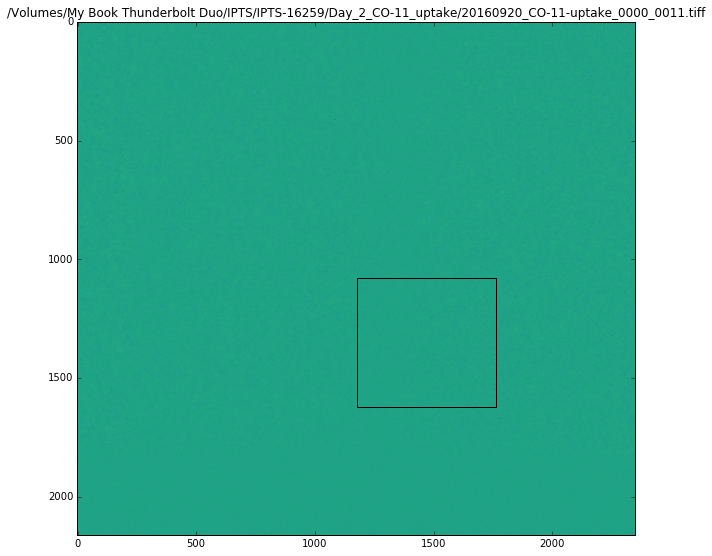

In [32]:
def plot_images_with_box(file_index, x_left, y_top, width, height):
    
    data = array_images[file_index][:, :]
    
    fig_box = plt.figure(figsize=(10, 10))
    ax_img = plt.subplot(111)
    
    ax_img.imshow(np.log(data), cmap='viridis')
    ax_img.set_title(list_files[file_index])
    ax_img.add_patch(patches.Rectangle((x_left, y_top), width, height, fill=False))
    
    return [x_left, y_top, width, height, fig_box]

number_of_files = len(list_files)
profile = interact(plot_images_with_box,
                  file_index = widgets.IntSlider( min=0, max=number_of_files, value=0, step=1, description='Image index'),
                  x_left = widgets.IntSlider( min=0, max=image_width-1, step=1, value=int(image_width/2)),
                  y_top = widgets.IntSlider( min=0, max=image_height-1, step=1, value=int(image_height/2)),
                  width = widgets.IntSlider( min=0, max=image_width-1, step=1, value=int(image_width/4)),
                  height = widgets.IntSlider( min=0, max=image_height-1, step=1, value=int(image_height/4)))
    

In [99]:
[_, _, _, _, fig_box] = profile.widget.result

## 5. calculate profile over range of images 

In [96]:
print(profile.widget.kwargs)
y_top = profile.widget.kwargs['y_top']
x_left = profile.widget.kwargs['x_left']
width = profile.widget.kwargs['width']
height = profile.widget.kwargs['height']

{'y_top': 123, 'width': 33, 'file_index': 0, 'height': 61, 'x_left': 66}


In [86]:
w = widgets.IntProgress()
w.max = 100
display(w)
index = 0

profile_array = []
for _image in array_images:
    _profile_image = _image[y_top:y_top+height, x_left:x_left+width]
    _value = np.sum(_profile_image)
    profile_array.append(_value)
    w.value = index
    index += 1

## 6. Display profile 

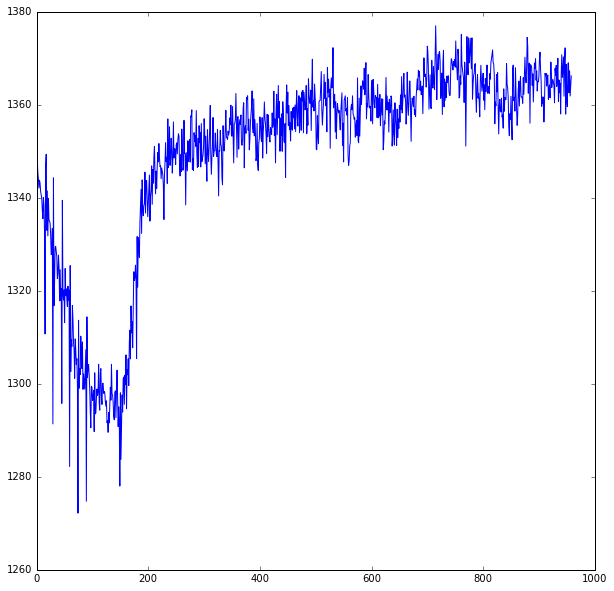

In [89]:
fig_profile = plt.figure(figsize=(10, 10))
plt.plot(profile_array)           

In [81]:
image_0 = array_images[0]

In [82]:
image_0.shape

(246, 132)

In [85]:
np.sum(image_0)

25064.322

## 7. Export report 

Select output folder

In [112]:
%gui qt
output_folder = gui_fname(dir = data_folder)

record the figure selection plot

In [116]:
step = 50 # jump by 50 files

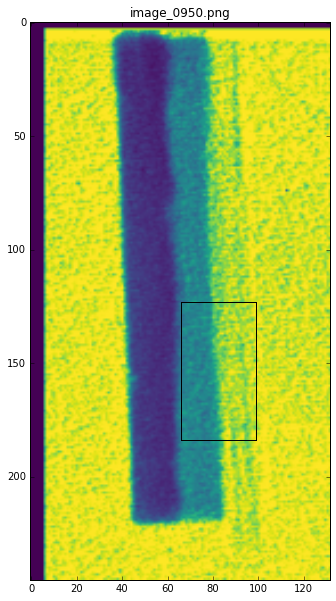

In [119]:
w = widgets.IntProgress()
w.max = int(number_of_files/50)
display(w)
index = 0

fig_box = plt.figure(figsize=(10, 10))
ax_img = plt.subplot(111)

counter = 0
for index in range(0, number_of_files, step):
    
    _image = array_images[index]
    _file = list_files[index].split(".")
    _file = ".".join([_file[0], "png"])
    _output_file = os.path.join(output_folder, _file)
    
    
    ax_img.imshow(_image, cmap='viridis')
    ax_img.set_title(_file)
    ax_img.add_patch(patches.Rectangle((x_left, y_top), width, height, fill=False))

    fig_box.savefig(_output_file)
    w.value = counter
    counter += 1


record the figure of the profile

In [120]:
_profile_file = os.path.join(output_folder, "profile_2d.png")
fig_profile.savefig(_profile_file)

record the data into txt file

In [137]:
_data_file = os.path.join(output_folder, "data_profile.txt")
f = open(_data_file, "w")

In [138]:
data = []
data.append("# y_top: %i\n" % y_top)
data.append("# x_left: %i\n" % x_left)
data.append("# width: %i\n" % width)
data.append("# height: %i\n" % height)

In [139]:
data.append("\n")
data.append("#index sum_counts\n")
for index, value in enumerate(profile_array):
    data.append("%i %i\n" %(index, value))

In [140]:
f.writelines(data)
f.close()